In [1]:
import os
os.chdir('D:\\Gnan\\DA\\KMU\\Prediction-COVID-19')
from utils import *

In [16]:
def N_in_dict(dic_files, list_N):
    
    i = 0
    for key, file in dic_files.items():
        dic_files[key] = [list_N[i], file]
        i += 1
    
    return dic_files
    
def Processing_SIR(file, city, N):
    df = pd.DataFrame()

    Recover = [7, 14]
    Reinfectable = 90

    df['Date'] = file['stdDay']
    df['city'] = file['gubun']

    # 사망자
    df['Death'] = file['deathCnt']                 # 누적 사망자
    df['Death_n'] = df['Death'].diff().fillna(0)   # 신규 사망자

    df['Inf_AC'] = file['defCnt']                  # 누적 감염자
    df['Inf_n'] = df['Inf_AC'].diff().fillna(0)    # 신규 감염자

    # 감염자
    df['Infected'] = df['Inf_AC']  
    df.iloc[Recover[1]:, -1] = (df.iloc[Recover[1]:, -1]
                               .reset_index(drop = True)
                               .sub(df.iloc[:len(df)-Recover[1], -1]))

    # 회복자
    df['Recovered'] = 0
    df.iloc[Recover[1]:, -1] = df.iloc[:len(df)-Recover[1], 4]
    df.iloc[Recover[1] + Reinfectable:, -1] = (df.iloc[Recover[1]+Reinfectable:, -1]
                                               .reset_index(drop = True)
                                               .sub(df.iloc[:len(df)-(Recover[1]+Reinfectable), 4]))
    df['Recovered'] = df['Recovered']-df['Death']
    df['Recovered_n'] = df['Recovered'].diff().fillna(0)  # 신규 회복자

    # 취약자
    df['Susceptible'] = N - df['Inf_AC']
    df.iloc[Reinfectable:, -1] = (df.iloc[Reinfectable:, -1]
                                  .reset_index(drop = True)
                                  .add(df.iloc[:len(df)-Reinfectable, 8]))
    df['Susceptible_n'] = df['Susceptible'].diff().fillna(0)   # 신규 취약자
    
    #df['alpha'] = df.iloc[1:, 10].reset_index(drop = True)
    #df.iloc[Reinfectable-1:, -1] = (df.iloc[Reinfectable-1:, -1]
    #                                .reset_index(drop = True)
    #                                .sub(df.iloc[:len(df)-(Reinfectable-1), 8]))
    #df.iloc[Reinfectable:, -1] = (df.iloc[Reinfectable:, -1]
    #                              .reset_index(drop = True)
    #                              .add(df.iloc[:len(df)-Reinfectable, 8]))
    #df['alpha'] = -1*N*df['alpha']/(df['Susceptible']*df['Infected'])
    #df.loc[df['alpha'] == 0, 'alpha'] = 0
    #df = df.replace([np.inf, -np.inf], np.nan).fillna(0)
    #
    #df_final = df[['Date', 'city', 'Death', 'Infected', 'Recovered', 'Susceptible', 'alpha']].copy()
    
    return df#_final

def Overlook(df, city):
    print(city, df['alpha'].describe())
    df.head()
    plt.plot(df['alpha'])

In [17]:
path = 'Data/Cleaned_deathCnt/*.csv'
dic_files = Load_files.load_files(path, -14, -12)

list_N = [1539277, 13527299, 3311631, 2622174, 
          1440908, 2389150, 1454068, 3353379, 
          9535432, 370439, 1122757, 2952839, 
          1834016, 1786855, 676518, 2121108, 1597774]

dic_files = N_in_dict(dic_files, list_N)

In [18]:
file = dic_files['강원'][1]
file

,deathCnt,defCnt,gubun,gubunEn,incDec,isolClearCnt,isolIngCnt,localOccCnt,overFlowCnt,qurRate,stdDay
0,0,0,강원,Gangwon-do,0,0,0,0,0,0.0,2020-01-20
1,0,0,강원,Gangwon-do,0,0,0,0,0,0.0,2020-01-21
2,0,0,강원,Gangwon-do,0,0,0,0,0,0.0,2020-01-22
3,0,0,강원,Gangwon-do,0,0,0,0,0,0.0,2020-01-23
4,0,0,강원,Gangwon-do,0,0,0,0,0,0.0,2020-01-24
...,...,...,...,...,...,...,...,...,...,...,...
1167,1320,905366,강원,Gangwon-do,213,0,0,213,0,58924.0,2023-04-01
1168,1320,905564,강원,Gangwon-do,198,0,0,198,0,58937.0,2023-04-02
1169,1320,905697,강원,Gangwon-do,133,0,0,133,0,58946.0,2023-04-03
1170,1321,905963,강원,Gangwon-do,266,0,0,264,2,58963.0,2023-04-04


In [20]:
dic_final = {}
for key, file in dic_files.items():
    df_final = Processing_SIR(file[1], key, file[0])
    dic_final[key] = df_final
    df_final.to_csv(f'Data/SIR/{key}_SIR.csv', index = False)
    #Overlook(df_final, key)

In [32]:
a = dic_final['서울']
a.loc[a['Death'] + a['Infected'] + a['Recovered'] + a['Susceptible'] == 9535432]

,Date,city,Death,Death_n,Inf_AC,Inf_n,Infected,Recovered,Recovered_n,Susceptible,Susceptible_n
0,2020-01-20,서울,0,0.0,0,0.0,0,0,0.0,9535432,0.0
1,2020-01-21,서울,0,0.0,0,0.0,0,0,0.0,9535432,0.0
2,2020-01-22,서울,0,0.0,0,0.0,0,0,0.0,9535432,0.0
3,2020-01-23,서울,0,0.0,0,0.0,0,0,0.0,9535432,0.0
4,2020-01-24,서울,0,0.0,1,1.0,1,0,0.0,9535431,-1.0
...,...,...,...,...,...,...,...,...,...,...,...
104,2020-05-03,서울,2,0.0,637,2.0,13,622,2.0,9534795,-2.0
105,2020-05-04,서울,2,0.0,637,0.0,13,622,0.0,9534795,0.0
106,2020-05-05,서울,2,0.0,637,0.0,11,624,2.0,9534795,0.0
107,2020-05-06,서울,2,0.0,637,0.0,9,626,2.0,9534795,0.0


In [36]:
pd.set_option('display.max_rows', None)
a[50:150]

,Date,city,Death,Death_n,Inf_AC,Inf_n,Infected,Recovered,Recovered_n,Susceptible,Susceptible_n
50,2020-03-10,서울,0,0.0,141,11.0,104,37,7.0,9535291,-11.0
51,2020-03-11,서울,0,0.0,194,53.0,149,45,8.0,9535238,-53.0
52,2020-03-12,서울,0,0.0,213,19.0,158,55,10.0,9535219,-19.0
53,2020-03-13,서울,0,0.0,225,12.0,163,62,7.0,9535207,-12.0
54,2020-03-14,서울,0,0.0,238,13.0,164,74,12.0,9535194,-13.0
55,2020-03-15,서울,0,0.0,247,9.0,165,82,8.0,9535185,-9.0
56,2020-03-16,서울,0,0.0,253,6.0,162,91,9.0,9535179,-6.0
57,2020-03-17,서울,0,0.0,265,12.0,167,98,7.0,9535167,-12.0
58,2020-03-18,서울,0,0.0,270,5.0,172,98,0.0,9535162,-5.0
59,2020-03-19,서울,0,0.0,282,12.0,179,103,5.0,9535150,-12.0


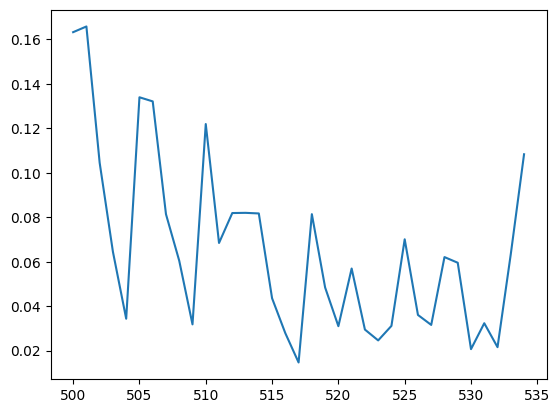

In [29]:
plt.plot(df_final['alpha'][500:535])